# How to properly prevent overfitting

🎯 **Goals of this challenge**
- **`Cross Validate`** a Deep Learning Model
- Give a **`Validation Set`** to the model
- Apply two techniques to prevent overfitting:
    - Use the **`Early Stopping`** criterion to prevent the Neural network from over-learning / over-fitting
    - **`Regularize`** your network
- Analyze the **`impact of the batch size and the number of epochs`** on the training of a Neural Network

In [7]:
# DATA MANIPULATION
import numpy as np
import pandas as pd

# DATA VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline

## Data: the `blobs` dataset

In [2]:
# BLOB DATASET
from sklearn.datasets import make_blobs

❓ **Question: generating a "blobs dataset"** ❓ 

First, let's generate some data using the [`make_blob`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function from Scikit-Learn

Generate:
* 2000 samples with 10 features each
* There should be 8 classes of blobs (`centers` argument), with `cluster_std` equal to 7. 

In [8]:
X, y = make_blobs(n_samples=2000, centers=8, n_features=10, cluster_std=7, random_state=0)
X.shape, y.shape

((2000, 10), (2000,))

❓ **Question: visualizing the dataset** ❓

All your samples have 10 features.
Plot one of the dimensions against another.

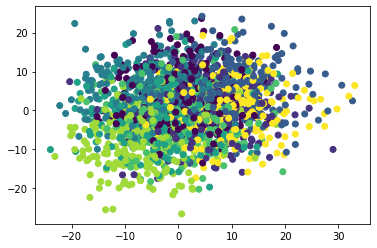

In [20]:
plt.scatter(X.T[0], X.T[1], c=y);

❓ **Question: "encoding" your categorical target** ❓ 

Use the **to_categorical** function from **tensorflow.keras** to convert `y` to `y_cat` which is the categorical representation of `y` with "*one-hot encoded*" columns.

In [24]:
from tensorflow.keras.utils import to_categorical 

2022-08-16 11:57:28.875712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 11:57:28.875756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [25]:
y_cat = to_categorical(y)

In [26]:
y.shape, y_cat.shape

((2000,), (2000, 8))


## (1) Cross Validation in Deep Learning

👩🏻‍🏫 In a previous challenge, we split the dataset into a train set and a test set at the beginning of the notebook. 

And then, we started to build different models which were trained on the train set and evaluated on the test set.

So, at the end of the day, we used the test set every time we evaluated our models and different hyperparameters. This is normal: we train on the train set and we evaluate on the test set.

However, we selected our _"best model"_ based on the score of each model. In other words, we _used_ the test set to select our best model, which is a sort of ❗️ `data-leakage` ❗️

🤔 What should I do? 

* A first good practice is to avoid using `random_state` or any deterministic separation between your train and test set. In that case, your test set will change every time you re-run your notebook. But this is far from being sufficient.

* To compare models properly, you have to run a cross-validation, a 10-fold split for instance. 

🧐 If you look at [sklearn.model_selection.cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html), this Cross Validation tool is designed for Machine Learning algorithms implemented in Scikit Learn... whereas we have been creating and using Neural Networks from Tensorflow/Keras.

🔥 Let's discover how to **Cross-Validate a Neural Network**.

❓ **Question: designing a Neural Network** ❓ 

First, write a function that generates a Neural Network with 3 layers:

<u>Architecture</u>
- an *input layer* with 25 neurons, the `relu` activation function and the appropriate `input_dim`
- a *hidden layer* with 10 neurons and the `relu` activation function.
- a *predictive layer* which is suited to the problem at hand (*multiclass classification*)

<u>Compilation</u>

The function should include a compilation method with:
- the *categorical_crossentropy* loss, 
- the *adam* optimizer 
- the *accuracy* metrics.

In [34]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models

In [40]:
def initialize_model():
    model = models.Sequential()
    
    model.add(layers.Dense(25, activation='relu', input_dim=X.shape[-1]))
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Dense(8, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', #multiple classes
                  optimizer='adam', 
                  metrics=['accuracy']) 
    
    return model


❓ **Question: Cross-Validating the Neural Net** ❓ 

🧑🏻‍💻 Write a _loop_ using the [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from Scikit-Learn.

* ✂️ Choose 10 splits to fit your model on the train data
* 🧪 Evaluate your model on the test data. Store the results of the evaluation into a `results` variable.

_Hints_:
* ⚖️ Do not forget to standardize your train data before fitting the neural network.
* 👌 Also, 150 epochs should be sufficient for a first approximation
* 🤝 As this is your first Deep Learning Cross Validation, you are guided. Uncomment the following cell and follow the steps.
* ⏳ Notice that we added `%% time` at the beginning of this Jupyter Notebook cell to display its running time and we encourage you to do so whenever you have expensive computations.

In [36]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

In [41]:
%%time

kf = KFold(n_splits=10)
kf.get_n_splits(X)

results = []

for train_index, test_index in kf.split(X):
    
    #Split the data into train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]
    
    # Scaling your data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize the model
    model = initialize_model()

    # Fit the model on the train data
    history = model.fit(X_train_scaled, 
                        y_train,
                        validation_data = (X_test_scaled, y_test),
                        epochs = 150,         # Play with this until your validation loss overfit
                        batch_size = 16,      # Let's keep a small batch size for faster iterations
                        verbose = 0)

    
    # Evaluate the model on the test data
    results.append(model.evaluate(X_test_scaled, y_test, verbose = 0))


CPU times: user 9min 38s, sys: 4min 3s, total: 13min 41s
Wall time: 5min 21s


In [42]:
results

[[0.7198391556739807, 0.7549999952316284],
 [0.7645971775054932, 0.7549999952316284],
 [0.6689544916152954, 0.7400000095367432],
 [0.7167247533798218, 0.7649999856948853],
 [0.7370364665985107, 0.7699999809265137],
 [0.8524723052978516, 0.7049999833106995],
 [0.8513737320899963, 0.7749999761581421],
 [0.787200927734375, 0.7350000143051147],
 [0.8157123327255249, 0.6899999976158142],
 [0.6620325446128845, 0.7549999952316284]]

In [83]:
accuracy = [el[1] for el in results]
accuracy

[0.7549999952316284,
 0.7549999952316284,
 0.7400000095367432,
 0.7649999856948853,
 0.7699999809265137,
 0.7049999833106995,
 0.7749999761581421,
 0.7350000143051147,
 0.6899999976158142,
 0.7549999952316284]

❓ **Question: Performance of the Cross Validated Network** ❓ 

Print the average accuracy of these 10 folds and the standard deviation of these 10 accuracy values.

In [85]:
np.mean(accuracy)

0.7444999933242797

In [86]:
np.std(accuracy)

0.026405487889236617

❗ **Remarks about the computational time** ❗

* 🤯 You probably encountered one of the main drawbacks of using a proper cross-validation for a Neural Network: **it takes a lot of time**! Therefore, for the rest of the Deep-Learning module, we will do ***only one split***. 

* 👮🏻‍♀️ But remember that this is not entirely correct and, for real-life applications and problems, you are encouraged to use a proper cross-validation technique.

* 💼 In general, what practitioners do, is that they split only once, as you did. And once they get to the end of their optimization, they launch a real cross-validation at 6 PM, go home and get the final results on the next day.

❓ **Question: Holdout Method** ❓ 

For the rest of the exercise (and of the Deep Learning module), split the dataset into a train set and a test set with a 70/30% training to test data ratio.

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.3)

In [99]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((1400, 10), (600, 10), (1400, 8), (600, 8))

## (2) How to prevent a Neural Network from overfitting?

### (2.1) Early Stopping

🚦 ***Stop the learning process before overfitting***

❓ **Question: illustrating how a Neural Network can easily overfit...** ❓ 

First things first, let's show that if we train the model for too long (for too many epochs) it will overfit the training data and will not be good at predicting on the test data.

To do this, train the same neural network (⚠️ do not forget to re-initialize it ⚠️) with `validation_data =(X_test, y_test)` and `epochs = 500`. Store the history in a `history` variable.

In [100]:
from tensorflow.keras.callbacks import EarlyStopping

In [101]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [123]:
%%time

#es = EarlyStopping(patience=20)

# Initialize the model
model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train_scaled, 
                    y_train,
                    validation_data = (X_test_scaled, y_test),
                    epochs = 500,         # Play with this until your validation loss overfit
                    batch_size = 16,      # Let's keep a small batch size for faster iterations
                    verbose = 1)
                    #callbacks=[es])

Epoch 1/500
88/88 [==============================] - 1s 4ms/step - loss: 2.0114 - accuracy: 0.1536 - val_loss: 1.8340 - val_accuracy: 0.3117
Epoch 2/500
88/88 [==============================] - 0s 3ms/step - loss: 1.7099 - accuracy: 0.3900 - val_loss: 1.5402 - val_accuracy: 0.5317
Epoch 3/500
88/88 [==============================] - 0s 3ms/step - loss: 1.4002 - accuracy: 0.5471 - val_loss: 1.2500 - val_accuracy: 0.6400
Epoch 4/500
88/88 [==============================] - 0s 3ms/step - loss: 1.1488 - accuracy: 0.6371 - val_loss: 1.0441 - val_accuracy: 0.6850
Epoch 5/500
88/88 [==============================] - 0s 2ms/step - loss: 0.9673 - accuracy: 0.6836 - val_loss: 0.8918 - val_accuracy: 0.7133
Epoch 6/500
88/88 [==============================] - 0s 3ms/step - loss: 0.8537 - accuracy: 0.7093 - val_loss: 0.8044 - val_accuracy: 0.7250
Epoch 7/500
88/88 [==============================] - 0s 3ms/step - loss: 0.7842 - accuracy: 0.7236 - val_loss: 0.7559 - val_accuracy: 0.7417
Epoch 8/500
8

88/88 [==============================] - 0s 3ms/step - loss: 0.5335 - accuracy: 0.7957 - val_loss: 0.6671 - val_accuracy: 0.7600
Epoch 59/500
88/88 [==============================] - 0s 3ms/step - loss: 0.5302 - accuracy: 0.7921 - val_loss: 0.6618 - val_accuracy: 0.7583
Epoch 60/500
88/88 [==============================] - 0s 3ms/step - loss: 0.5265 - accuracy: 0.7879 - val_loss: 0.6662 - val_accuracy: 0.7600
Epoch 61/500
88/88 [==============================] - 0s 3ms/step - loss: 0.5273 - accuracy: 0.7900 - val_loss: 0.6717 - val_accuracy: 0.7533
Epoch 62/500
88/88 [==============================] - 0s 3ms/step - loss: 0.5263 - accuracy: 0.7879 - val_loss: 0.6572 - val_accuracy: 0.7617
Epoch 63/500
88/88 [==============================] - 0s 3ms/step - loss: 0.5221 - accuracy: 0.7964 - val_loss: 0.6712 - val_accuracy: 0.7533
Epoch 64/500
88/88 [==============================] - 0s 3ms/step - loss: 0.5259 - accuracy: 0.7957 - val_loss: 0.6635 - val_accuracy: 0.7517
Epoch 65/500
88/88 

Epoch 116/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.8079 - val_loss: 0.7175 - val_accuracy: 0.7567
Epoch 117/500
88/88 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.8079 - val_loss: 0.7353 - val_accuracy: 0.7433
Epoch 118/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4842 - accuracy: 0.8050 - val_loss: 0.7270 - val_accuracy: 0.7533
Epoch 119/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4820 - accuracy: 0.8100 - val_loss: 0.7258 - val_accuracy: 0.7467
Epoch 120/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4808 - accuracy: 0.8093 - val_loss: 0.7160 - val_accuracy: 0.7567
Epoch 121/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4788 - accuracy: 0.8157 - val_loss: 0.7256 - val_accuracy: 0.7483
Epoch 122/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4798 - accuracy: 0.8064 - val_loss: 0.7307 - val_accuracy: 0.7567

88/88 [==============================] - 0s 3ms/step - loss: 0.4550 - accuracy: 0.8207 - val_loss: 0.7845 - val_accuracy: 0.7433
Epoch 174/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4529 - accuracy: 0.8229 - val_loss: 0.7805 - val_accuracy: 0.7483
Epoch 175/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4523 - accuracy: 0.8229 - val_loss: 0.7896 - val_accuracy: 0.7483
Epoch 176/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4523 - accuracy: 0.8229 - val_loss: 0.8016 - val_accuracy: 0.7467
Epoch 177/500
88/88 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.8214 - val_loss: 0.7985 - val_accuracy: 0.7483
Epoch 178/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4501 - accuracy: 0.8214 - val_loss: 0.7851 - val_accuracy: 0.7483
Epoch 179/500
88/88 [==============================] - 0s 4ms/step - loss: 0.4499 - accuracy: 0.8257 - val_loss: 0.7883 - val_accuracy: 0.7483
Epoch 180/500

88/88 [==============================] - 0s 3ms/step - loss: 0.4315 - accuracy: 0.8271 - val_loss: 0.8527 - val_accuracy: 0.7450
Epoch 231/500
88/88 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.8286 - val_loss: 0.8452 - val_accuracy: 0.7483
Epoch 232/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4312 - accuracy: 0.8279 - val_loss: 0.8431 - val_accuracy: 0.7533
Epoch 233/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4311 - accuracy: 0.8300 - val_loss: 0.8538 - val_accuracy: 0.7467
Epoch 234/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.8264 - val_loss: 0.8558 - val_accuracy: 0.7400
Epoch 235/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4301 - accuracy: 0.8336 - val_loss: 0.8610 - val_accuracy: 0.7483
Epoch 236/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4303 - accuracy: 0.8271 - val_loss: 0.8434 - val_accuracy: 0.7500
Epoch 237/500

88/88 [==============================] - 0s 3ms/step - loss: 0.4151 - accuracy: 0.8350 - val_loss: 0.9191 - val_accuracy: 0.7367
Epoch 288/500
88/88 [==============================] - 0s 2ms/step - loss: 0.4144 - accuracy: 0.8343 - val_loss: 0.9071 - val_accuracy: 0.7417
Epoch 289/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4095 - accuracy: 0.8386 - val_loss: 0.8886 - val_accuracy: 0.7500
Epoch 290/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4125 - accuracy: 0.8357 - val_loss: 0.8884 - val_accuracy: 0.7467
Epoch 291/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4101 - accuracy: 0.8386 - val_loss: 0.9038 - val_accuracy: 0.7400
Epoch 292/500
88/88 [==============================] - 0s 3ms/step - loss: 0.4101 - accuracy: 0.8400 - val_loss: 0.9152 - val_accuracy: 0.7467
Epoch 293/500
88/88 [==============================] - 0s 2ms/step - loss: 0.4116 - accuracy: 0.8429 - val_loss: 0.9116 - val_accuracy: 0.7433
Epoch 294/500

88/88 [==============================] - 0s 3ms/step - loss: 0.3989 - accuracy: 0.8379 - val_loss: 0.9758 - val_accuracy: 0.7267
Epoch 345/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3956 - accuracy: 0.8429 - val_loss: 0.9579 - val_accuracy: 0.7333
Epoch 346/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3962 - accuracy: 0.8379 - val_loss: 0.9491 - val_accuracy: 0.7350
Epoch 347/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3995 - accuracy: 0.8386 - val_loss: 0.9616 - val_accuracy: 0.7233
Epoch 348/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3953 - accuracy: 0.8507 - val_loss: 0.9686 - val_accuracy: 0.7233
Epoch 349/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3970 - accuracy: 0.8464 - val_loss: 0.9746 - val_accuracy: 0.7300
Epoch 350/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3956 - accuracy: 0.8457 - val_loss: 0.9689 - val_accuracy: 0.7267
Epoch 351/500

88/88 [==============================] - 0s 3ms/step - loss: 0.3807 - accuracy: 0.8564 - val_loss: 1.0312 - val_accuracy: 0.7217
Epoch 402/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.8586 - val_loss: 1.0462 - val_accuracy: 0.7133
Epoch 403/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3800 - accuracy: 0.8543 - val_loss: 1.0443 - val_accuracy: 0.7200
Epoch 404/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.8529 - val_loss: 1.0369 - val_accuracy: 0.7267
Epoch 405/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3822 - accuracy: 0.8507 - val_loss: 1.0362 - val_accuracy: 0.7167
Epoch 406/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3814 - accuracy: 0.8557 - val_loss: 1.0421 - val_accuracy: 0.7217
Epoch 407/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3767 - accuracy: 0.8536 - val_loss: 1.0526 - val_accuracy: 0.7217
Epoch 408/500

88/88 [==============================] - 0s 3ms/step - loss: 0.3694 - accuracy: 0.8593 - val_loss: 1.0945 - val_accuracy: 0.7083
Epoch 459/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3706 - accuracy: 0.8664 - val_loss: 1.0737 - val_accuracy: 0.7183
Epoch 460/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3723 - accuracy: 0.8586 - val_loss: 1.1059 - val_accuracy: 0.7200
Epoch 461/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3688 - accuracy: 0.8621 - val_loss: 1.0955 - val_accuracy: 0.7217
Epoch 462/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3725 - accuracy: 0.8579 - val_loss: 1.0832 - val_accuracy: 0.7183
Epoch 463/500
88/88 [==============================] - 0s 2ms/step - loss: 0.3690 - accuracy: 0.8536 - val_loss: 1.0924 - val_accuracy: 0.7200
Epoch 464/500
88/88 [==============================] - 0s 3ms/step - loss: 0.3679 - accuracy: 0.8607 - val_loss: 1.0850 - val_accuracy: 0.7300
Epoch 465/500

❓ **Question: your Neural Network's performance** ❓ 

Evaluate the model on the test set and print the accuracy.

In [126]:
res = model.evaluate(X_test_scaled, y_test, verbose = 0)
accuracy = res[1]
round(accuracy, 3)

0.715

❓ **Question: Learnings about number of epochs** ❓ 

Plot the history of the model with `plot_loss_accuracy` function that we coded for you.

What do you observe? 

In [121]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

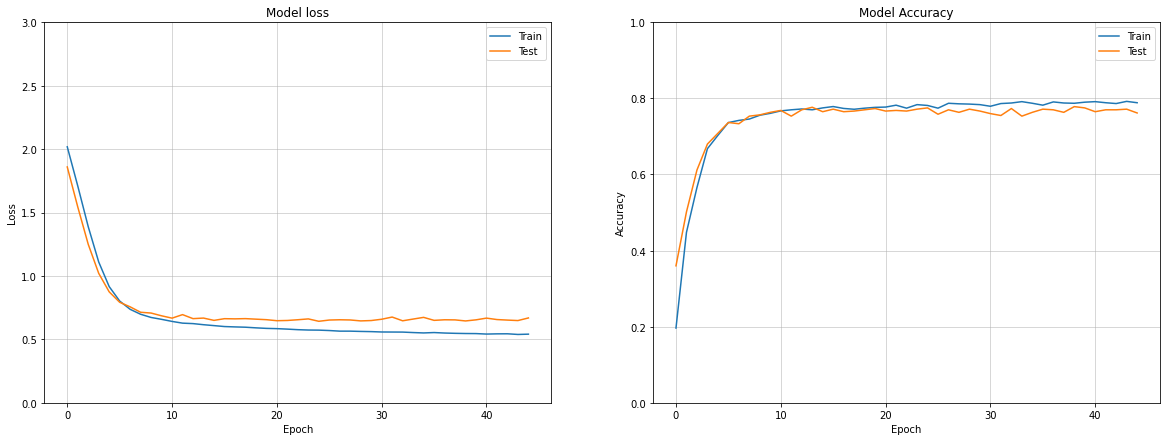

In [122]:
plot_loss_accuracy(history) #with patience = 20

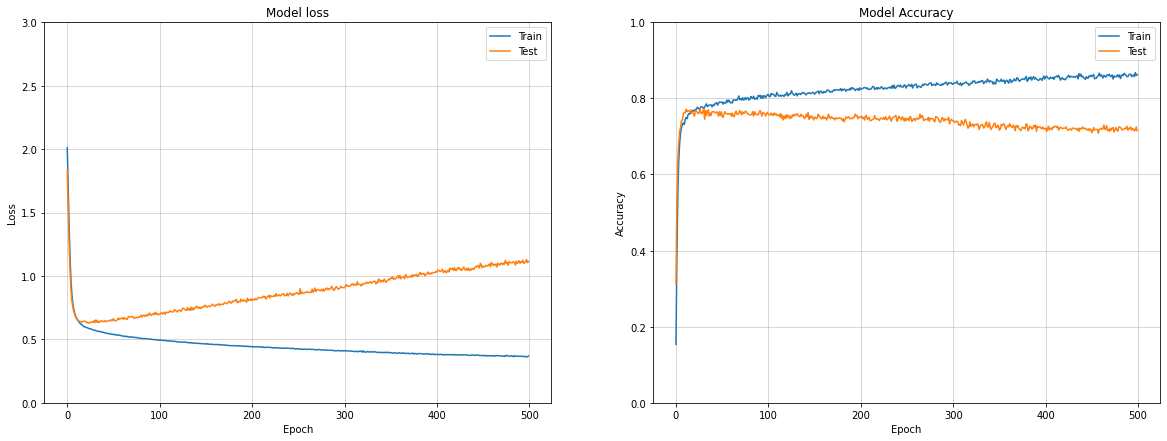

In [124]:
plot_loss_accuracy(history) #without patience

> YOUR ANSWER HERE

👩🏻‍🏫 We clearly see that ***the number of epochs we choose has a strong influence on the final results***: 

* **INSUFFICIENT NUMBER OF EPOCHS $\implies$ UNDERFITTING**:
    * The algorithm is not optimal as it's ***loss function has not converged yet***, 
    * i.e. it hasn't learned enough from the training data. 
* **TOO MANY EPOCHS** $\implies$ **OVERFITTING**: 
    * Our neural network has ***learned too much from the training data***, even it's noisy information... 
    * and the algorithm ***does not generalize well on test data***.

🚦 Basically, what we want is to do is ***stop the algorithm when the test loss is minimal*** (or when the test metrics is maximal).



---

🧑🏻‍🏫 Let's introduce the **`Early Stopping`** criterion.

The Early Stopping criterion is a way to ***automatically stop training of the algorithm*** before reaching the number of epochs that was originally set.

🕵🏻‍♂️ How does it work?

> Basically, it uses part of the dataset to check whether the "test" loss has stopped improving. You cannot use the test data itself to check that, that would be data leakage... Instead, we will ***use a subset of the initial training data***, called the ***validation set***.


<img src="validation_set.png" alt="Validation set" style="height:200px;"/>

✂️ To split the training data, we use the **`validation_split`** keyword in the **`.fit()`**: it sets the percentage of data from the initial training set to be used in the **validation set**. 

❗️If you select a _validation_split_ of 30% for example, the last 30% rows of the training set will be used in the validation set. You can use **`shuffle = True`** to add some randomness.

💡 On top of the _validation_split_, we use the **`callbacks`** keyword in the **`.fit()`** to call the Early Stopping criterion at the end of each epoch. You can check additional information in the ["train_and_evaluate" documentation for Tensorflow/Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate)

---

❓ **Question: Observing the Early Stopping criterion** ❓ 

Run the following code and plot the history.

In [130]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping()

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train_scaled, y_train,
                    validation_split = 0.3,
                    shuffle = True,
                    epochs = 500,
                    batch_size = 16, 
                    verbose = 1, 
                    callbacks = [es])

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 1.9561 - accuracy: 0.2656 - val_loss: 1.8617 - val_accuracy: 0.3230
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 1.7370 - accuracy: 0.3800 - val_loss: 1.6319 - val_accuracy: 0.4062
CPU times: user 1.27 s, sys: 297 ms, total: 1.57 s
Wall time: 1.01 s


❓ **Question: Evaluate this model that was stopped earlier** ❓

_(Also look at the historical losses)_

In [132]:
res = model.evaluate(X_test_scaled, y_test, verbose = 0)
res

[1.6382942199707031, 0.4116666615009308]

❗ **The problem with a strict Early Stopping** ❗ 

* The problem, with this type of approach, is that as soon as the loss of the validation set increases, the model stops. 

* However, as a neural network's convergence is stochastic, The loss may slightly increase before decreasing again. 

✅ The `EarlyStopping` criterion has a **`patience`** keyword that ***defines how many consecutive epochs without any loss decrease*** are allowed before we stop the training procedure.



❓ **Question: Early Stopping with patience** ❓ 

Use the `EarlyStopping` criterion with a patience of 30 epochs, plot the results and print the accuracy on the test set

In [133]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=30)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train_scaled, y_train,
                    validation_split = 0.3,
                    shuffle = True,
                    epochs = 500,
                    batch_size = 16, 
                    verbose = 1, 
                    callbacks = [es])

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 2.0884 - accuracy: 0.1491 - val_loss: 2.0059 - val_accuracy: 0.1805
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 1.9450 - accuracy: 0.2533 - val_loss: 1.8811 - val_accuracy: 0.2993
Epoch 3/500
62/62 [==============================] - 0s 3ms/step - loss: 1.8019 - accuracy: 0.3718 - val_loss: 1.7294 - val_accuracy: 0.3848
Epoch 4/500
62/62 [==============================] - 0s 3ms/step - loss: 1.6380 - accuracy: 0.4515 - val_loss: 1.5639 - val_accuracy: 0.4822
Epoch 5/500
62/62 [==============================] - 0s 3ms/step - loss: 1.4704 - accuracy: 0.5087 - val_loss: 1.3966 - val_accuracy: 0.5463
Epoch 6/500
62/62 [==============================] - 0s 3ms/step - loss: 1.2974 - accuracy: 0.5700 - val_loss: 1.2197 - val_accuracy: 0.5962
Epoch 7/500
62/62 [==============================] - 0s 3ms/step - loss: 1.1218 - accuracy: 0.6404 - val_loss: 1.0614 - val_accuracy: 0.6627
Epoch 8/500
6

CPU times: user 18.6 s, sys: 5.94 s, total: 24.6 s
Wall time: 11.3 s


In [134]:
res = model.evaluate(X_test_scaled, y_test, verbose = 0)
accuracy = res[1]
round(accuracy, 3)

0.745

🧑🏻‍🏫 **Remarks**


* 📉 The model continues to converge even though it's loss function had some consecutive loss increases/decreases w.r.t. to the number of epochs. 

* 🤷🏻‍♂️ The `patience` number to select is highly related to the task at hand and there is not any general rule of thumb. 

* 🧑🏻‍🏫 If you selected a high patience value for your Early Stopping:
    * 🤞 Your Neural Net should theoretically still stop training before the end (not always the case if your number of epochs is too low...)
    * ❗️ Your validation loss will increase again after reaching a minimum value... but ideally, you want it to be as low as possible. The validation loss potentially reaches a minimum for certain weights at a certain epoch. 
        * 🤔 How to collect these weights? 
    
📚 The Early Stopping criterion enables you to:
- *stop the convergence*
- *restore the best weights of the Neural Network when it had the lowest error level (or the best score) on the validation set*, thanks to **`restore_best_weights = True`** (that is set to `False` by default).



❓ **Question: restore the best weights of a model** ❓ 

* Run the model with an Early Stopping criterion that will restore the best weights of the Neural Net
* Plot the loss and accuracy 
* Print the accuracy on the test set

In [136]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=30, restore_best_weights = True)

model = initialize_model()

# Fit the model on the train data
history = model.fit(X_train_scaled, y_train,
                    validation_split = 0.3,
                    shuffle = True,
                    epochs = 500,
                    batch_size = 16, 
                    verbose = 1, 
                    callbacks = [es])

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 2.0487 - accuracy: 0.2125 - val_loss: 1.9364 - val_accuracy: 0.2542
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 1.8350 - accuracy: 0.3034 - val_loss: 1.7468 - val_accuracy: 0.3373
Epoch 3/500
62/62 [==============================] - 0s 3ms/step - loss: 1.6526 - accuracy: 0.4055 - val_loss: 1.5728 - val_accuracy: 0.4466
Epoch 4/500
62/62 [==============================] - 0s 3ms/step - loss: 1.4809 - accuracy: 0.5352 - val_loss: 1.4040 - val_accuracy: 0.5724
Epoch 5/500
62/62 [==============================] - 0s 3ms/step - loss: 1.3130 - accuracy: 0.6108 - val_loss: 1.2488 - val_accuracy: 0.6437
Epoch 6/500
62/62 [==============================] - 0s 3ms/step - loss: 1.1599 - accuracy: 0.6639 - val_loss: 1.1025 - val_accuracy: 0.6770
Epoch 7/500
62/62 [==============================] - 0s 3ms/step - loss: 1.0302 - accuracy: 0.6915 - val_loss: 0.9861 - val_accuracy: 0.7078
Epoch 8/500
6

Epoch 59/500
62/62 [==============================] - 0s 3ms/step - loss: 0.5280 - accuracy: 0.7916 - val_loss: 0.6873 - val_accuracy: 0.7458
Epoch 60/500
62/62 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.7937 - val_loss: 0.6931 - val_accuracy: 0.7435
CPU times: user 19.2 s, sys: 6.54 s, total: 25.8 s
Wall time: 11.6 s


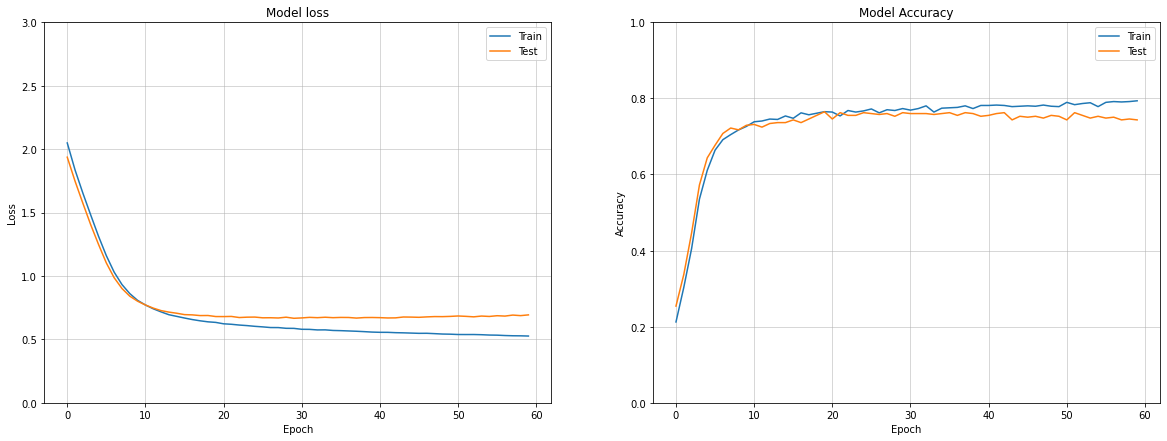

In [137]:
plot_loss_accuracy(history)

In [138]:
res = model.evaluate(X_test_scaled, y_test, verbose = 0)
accuracy = res[1]
round(accuracy, 3)

0.78

🥡 <u>Takeaways from the Early Stopping criterion</u>:

* You can look at the [Early Stopping documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to play with other parameters

*  No longer need to have a look at the number of epochs as long as the model hits the stopping criterion. So, in the future, you should set a large number of epochs and the Early Stopping criterion will take care of stopping the training procedure before the model overfits! 

### (2.2) Batch-size & Epochs

🕵️‍♀️ Let's investigate the impact of the batch size on training a Neural Network and how we can use it to control how fast the parameters are updated.

❓ **Question: playing with the batch size** ❓ 

Let's run the previous model with ***different batch sizes*** (with the Early Stopping criterion included) and plot the results.

👉 Run the following cell

CPU times: user 2min 19s, sys: 1min, total: 3min 19s
Wall time: 1min 19s


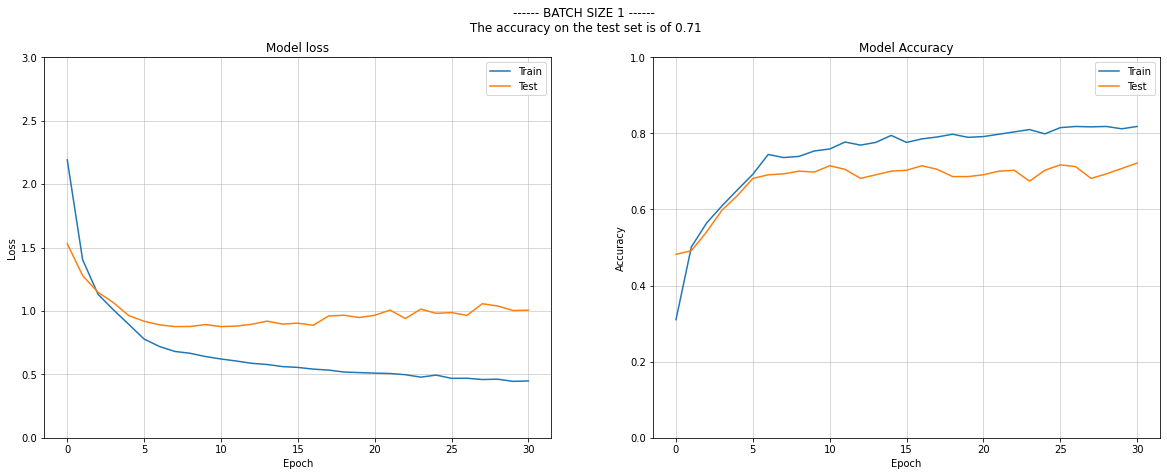

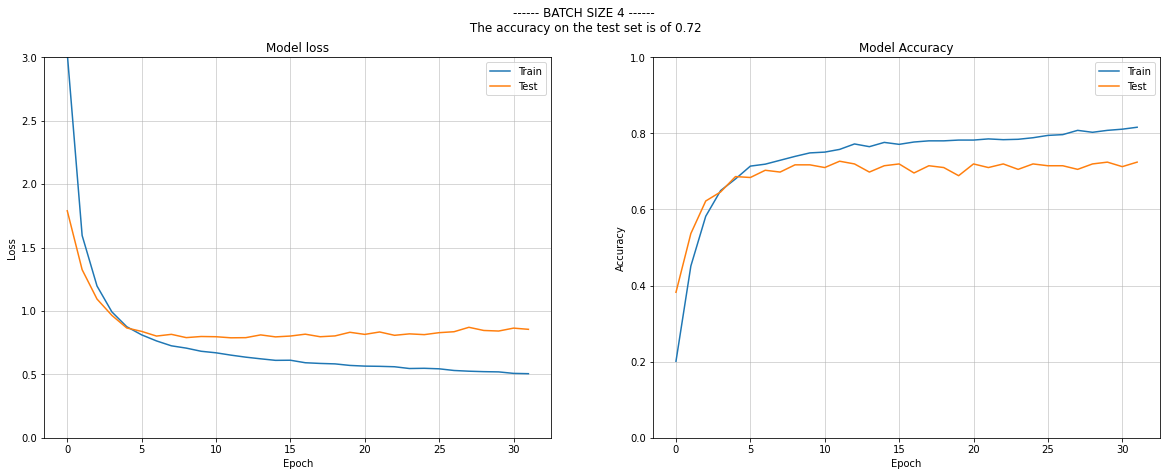

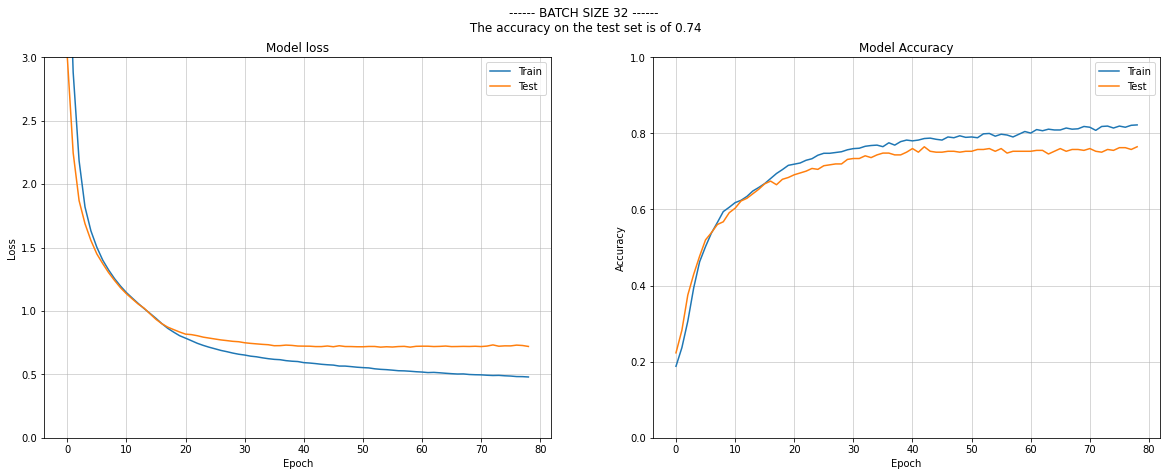

In [139]:
%%time
# RUN THIS CELL
es = EarlyStopping(patience=20, restore_best_weights=True)

for batch_size in [1, 4, 32]:
    
    model = initialize_model()

    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        epochs = 500,
                        batch_size = batch_size, 
                        verbose = 0, 
                        callbacks = [es])

    results = model.evaluate(X_test, y_test, verbose=0)
    plot_loss_accuracy(history, title=f'------ BATCH SIZE {batch_size} ------\n The accuracy on the test set is of {results[1]:.2f}')

❓ **Question: impact of the batch size on the convergence of a Neural Network** ❓ 

Look at the oscillations of the accuracy and the loss with respect to the batch size number. 

Is this coherent with what we saw when playing with the Tensorflow Playground? 

> Your answer here

❓ **Questions about the number of parameters' updates** ❓ 

* How many optimizations of the weights are done within one epoch (with respect to the number of observations and the batch size)? 
* Does one epoch have more weight updates with a large or a small batch size?

> Your answer here

<details>
    <summary><i>Explanations</i></summary>


***`BEGIN_EXPLANATIONS`***   
        
Copy-paste this code in a new cell, run it and observe.
        
```python
print(f"There are {X_train.shape[0]} rows in the training set")

batch_size = 16
epochs = 2

model = initialize_model()

history = model.fit(X_train, 
                    y_train,
                    validation_split = 0.3,
                    epochs = epochs,
                    batch_size = batch_size, 
                    verbose = 1)        
```        


<u><b><i>Number of parameters' updates:</i></b></u>

* There are 1400 rows in the training set:
    * $ 70 \% \times 1400 = 980 $ rows are used as the train set within the training set
    * $ 30 \% \times 1400 = 420 $ rows are used as the validation set  

* For each epoch, we run a forward/backward propagation $ \large \lceil \frac{980}{batch size} \rceil = \lceil \frac{980}{16}\rceil = 62$ times

* Without the Early Stopping Criterion, we will have overall _number of_ $ epochs \times 62 = 2 \times 62 = 124 $ iterations 
        
<u><b><i>Impact of the batch size:</i></b></u>

The smaller the batch size 

$ \implies $ The more sub-iterations will be done 

$ \implies $ Parameters will be updated more frequently 

$ \implies $ We may need less epochs 

_(but we also don't care as much about the number of epochs if we use an Early Stopping Criterion with patience anyway)_    

***`END_EXPLANATIONS`***    
    
</details>    

In [140]:
batch_size = 16
epochs = 2

model = initialize_model()

history = model.fit(X_train, 
                    y_train,
                    validation_split = 0.3,
                    epochs = epochs,
                    batch_size = batch_size, 
                    verbose = 1)

Epoch 1/2
62/62 [==============================] - 1s 5ms/step - loss: 3.8546 - accuracy: 0.1430 - val_loss: 2.4243 - val_accuracy: 0.1710
Epoch 2/2
62/62 [==============================] - 0s 3ms/step - loss: 2.0232 - accuracy: 0.3023 - val_loss: 1.7434 - val_accuracy: 0.3492


### (2.3) Regularization

❗️ ***Neural Networks with complex architectures can quickly lead to overfitting*** (_"too many" layers and/or neurons..._). ❗️

🔥 But as Dense Neural Networks are just activated linear regressions, the weights can be constrained using L1, L2 or L1-L2 penalties!


🚓 So, let's apply some L2 or L1 penalties to these neurons. As in Machine Learning, these penalties are called ***`Regularizers`***.



📚 <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers">**tensorflow/keras/regularizers**</a>

❓ **Initial Question: observing overfitting one more time before regularizing...**❓
 
* First, let's initialize a model that has too many parameters for the task such that it overfits the training data quickly. _To that purpose, let's not use any Early Stopping criterion._

🎁 Let's not waste time re-coding something that you are now used to, just run the following cell and observe what is happening 👇

The accuracy on the test set is 0.66...
...whereas the accuracy on the training set is 0.85!


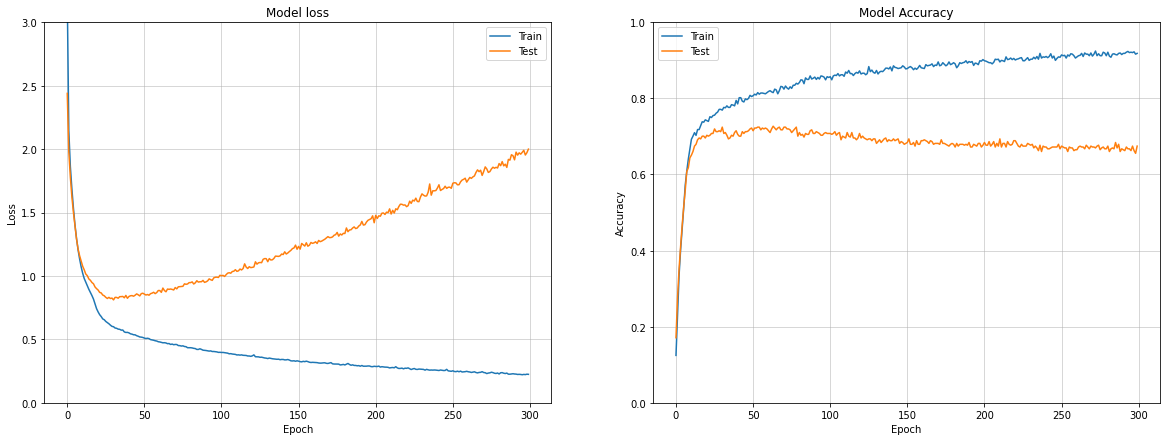

In [141]:
# RUN THIS CELL

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 3. Training 
history = model.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
                    batch_size = 16, 
                    verbose=0)

# 4. Evaluation
results_train = model.evaluate(X_train, y_train, verbose = 0)
results_test = model.evaluate(X_test, y_test, verbose = 0)


# 5. Looking back at what happened during the training phase
print(f'The accuracy on the test set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')
plot_loss_accuracy(history)

☝️ In our *over-parametrized network*, ***some neurons became too specific to the given training data***, preventing the network from generalizing to new data. 

😕 This led to some overfitting...! 

❓ **Question: studying the impact of regularization on the Neural Net**❓
 
* Change the previous code to integrate a L2 or L1 regularizer to your Dense Layers.

In [142]:
from tensorflow.keras import regularizers

In [145]:
%%time

es = EarlyStopping(patience=20, restore_best_weights=True)

reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dense(10, activation='relu', activity_regularizer=reg_l1_l2))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 3. Training 
history = model.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
                    batch_size = 16, 
                    verbose=0,
                    callbacks = [es])

CPU times: user 20.8 s, sys: 7.76 s, total: 28.6 s
Wall time: 11.9 s


### (2.4) Dropout layers

✂️ **`Dropout Layers`** ✂️

- ✅ They are super straightforward to code 
- 👩🏻‍🏫 But what is going on _"under the hood"_ ? (You love this expression right? 😏)

<u><i>Introduction to Dropout Layers</i><u>

* Their role is to randomly cancel the output of some neurons during the training phase
* It prevents the network from getting too specific to the input data. With Dropout layers,
    - No neuron can overspecialize in learning a pattern of the dataset because it's output sometimes canceled by the Dropout Layer
    - Overall, a Dropout Layer forces the information of an input to be spread across multiple neurons instead of only one specific neuron

<details>
    <summary><i>[optional] Click this for further explanations about Dropout Layers</i></summary>

🤔 Remember what we said about ***neurons becoming too specific***? 

---

⚽️ *An analogy with football:* 

Think about a football team. There are 11 players on the pitch, but there are also players on the bench, what for ? 
* The coach may want to substitute injured or tired players during the game
* The team may be:
    - losing the game and willing to replace a midfielder with a more ***versatile player*** who can be more offensive (= ***mix of*** midfielder/attacker role) 
    - winning the game and would like to secure the result by replacing a midfielder with a more ***versatile player*** who can be more defense ( = ***mix of*** midfielder/defense role)
    
💡 Well, in a Neural Net, there is also a risk that a neuron over-specializes in detecting one pattern, whereas it would be more advisable to keep it more versatile.
    
---

📚 **The goal of [Dropout layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) is to prevent neurons from over-specializing**.

🧑🏻‍🏫 How do Dropout layers work? 

* 👉 When we apply a **Dropout rate** of 20% to a layer $k$, 20% of the ***selected neurons*** will have their ***weights temporarily set to 0*** , which has the following consequences:
    1. A neuron computed at layer $k+1$ considers all the weights as usual, but since some of them were temporarily set to 0, they were “ignored” while creating the neurons of this layer $k+1$
    2. Once a batch of data points have been seen by the Neural Network (**forward propagation**) and 80% of the weights in a layer optimized/updated (**backward propagation** with the **adam** optimizer), the Neural Network moves on to the forward propagation of the next batch, where it will use:
        * 80% of the weights, those which were updated
        * 20% of weights, those which were previously ignored (which kept their original values and were actually not set in stone to 0 but just temporarily)
        * Based on these weights, we will again go through this Dropout Layer which again is going to ignore 20% of the weights of a given layer temporarily. Be careful, the selection of these 20% being random, the weights which will be ignored this time won't necessarily be the same weights as before!

* 👉 Think about the ***Dropout Rate*** as a ***sampling with replacement***

* 👉 By ***randomly shutting down*** different neurons at different epochs, we ***force the datapoints*** to be analyzed by different neurons. At the end of the day, these neurons will become ***more versatile*** instead of overspecializing!
    
</details>

---

❓ **Question: studying the impact of Dropout layers on the Neural Net**❓

* Include some Dropout layers in the architecture of your original model. 
_(Don't add regularizers here)_

* What can you observe about the convergence of your model? What about it's ability to generalize? 

In [148]:
%%time

es = EarlyStopping(patience=20, restore_best_weights=True)

reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(10, activation='relu', activity_regularizer=reg_l1_l2))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 3. Training 
history = model.fit(X_train, y_train,
                    validation_split = 0.3,
                    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
                    batch_size = 16, 
                    verbose=1,
                    callbacks = [es])

Epoch 1/300
62/62 [==============================] - 1s 6ms/step - loss: 6.3803 - accuracy: 0.1685 - val_loss: 2.7828 - val_accuracy: 0.2138
Epoch 2/300
62/62 [==============================] - 0s 4ms/step - loss: 4.2882 - accuracy: 0.1716 - val_loss: 2.2089 - val_accuracy: 0.2328
Epoch 3/300
62/62 [==============================] - 0s 3ms/step - loss: 3.4958 - accuracy: 0.1869 - val_loss: 2.0179 - val_accuracy: 0.2423
Epoch 4/300
62/62 [==============================] - 0s 3ms/step - loss: 2.9594 - accuracy: 0.1828 - val_loss: 1.9752 - val_accuracy: 0.2280
Epoch 5/300
62/62 [==============================] - 0s 3ms/step - loss: 2.5783 - accuracy: 0.1757 - val_loss: 1.9752 - val_accuracy: 0.2185
Epoch 6/300
62/62 [==============================] - 0s 3ms/step - loss: 2.5518 - accuracy: 0.1583 - val_loss: 1.9876 - val_accuracy: 0.1876
Epoch 7/300
62/62 [==============================] - 0s 4ms/step - loss: 2.2867 - accuracy: 0.1736 - val_loss: 1.9928 - val_accuracy: 0.1948
Epoch 8/300
6

Epoch 59/300
62/62 [==============================] - 0s 3ms/step - loss: 1.5686 - accuracy: 0.3667 - val_loss: 1.3006 - val_accuracy: 0.5986
Epoch 60/300
62/62 [==============================] - 0s 3ms/step - loss: 1.5826 - accuracy: 0.3933 - val_loss: 1.2833 - val_accuracy: 0.5986
Epoch 61/300
62/62 [==============================] - 0s 3ms/step - loss: 1.5802 - accuracy: 0.3902 - val_loss: 1.2759 - val_accuracy: 0.6152
Epoch 62/300
62/62 [==============================] - 0s 3ms/step - loss: 1.5553 - accuracy: 0.4137 - val_loss: 1.2699 - val_accuracy: 0.5938
Epoch 63/300
62/62 [==============================] - 0s 3ms/step - loss: 1.5312 - accuracy: 0.4065 - val_loss: 1.2625 - val_accuracy: 0.6128
Epoch 64/300
62/62 [==============================] - 0s 4ms/step - loss: 1.5091 - accuracy: 0.4259 - val_loss: 1.2666 - val_accuracy: 0.5962
Epoch 65/300
62/62 [==============================] - 0s 3ms/step - loss: 1.5404 - accuracy: 0.4178 - val_loss: 1.2702 - val_accuracy: 0.5962
Epoch 

62/62 [==============================] - 0s 3ms/step - loss: 1.3790 - accuracy: 0.4709 - val_loss: 1.1053 - val_accuracy: 0.6698
Epoch 117/300
62/62 [==============================] - 0s 3ms/step - loss: 1.4121 - accuracy: 0.4627 - val_loss: 1.1031 - val_accuracy: 0.6960
Epoch 118/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3883 - accuracy: 0.4862 - val_loss: 1.0972 - val_accuracy: 0.6817
Epoch 119/300
62/62 [==============================] - 0s 3ms/step - loss: 1.4178 - accuracy: 0.4331 - val_loss: 1.1046 - val_accuracy: 0.6651
Epoch 120/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3917 - accuracy: 0.4525 - val_loss: 1.1115 - val_accuracy: 0.6722
Epoch 121/300
62/62 [==============================] - 0s 4ms/step - loss: 1.3578 - accuracy: 0.4893 - val_loss: 1.1084 - val_accuracy: 0.6627
Epoch 122/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3844 - accuracy: 0.4341 - val_loss: 1.0917 - val_accuracy: 0.6770
Epoch 123/300

62/62 [==============================] - 0s 3ms/step - loss: 1.3011 - accuracy: 0.4862 - val_loss: 1.0544 - val_accuracy: 0.6651
Epoch 174/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3269 - accuracy: 0.4923 - val_loss: 1.0664 - val_accuracy: 0.6556
Epoch 175/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3350 - accuracy: 0.4944 - val_loss: 1.0644 - val_accuracy: 0.6746
Epoch 176/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3268 - accuracy: 0.4944 - val_loss: 1.0675 - val_accuracy: 0.6746
Epoch 177/300
62/62 [==============================] - 0s 3ms/step - loss: 1.2934 - accuracy: 0.4995 - val_loss: 1.0473 - val_accuracy: 0.6770
Epoch 178/300
62/62 [==============================] - 0s 4ms/step - loss: 1.3028 - accuracy: 0.5128 - val_loss: 1.0392 - val_accuracy: 0.6888
Epoch 179/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3462 - accuracy: 0.4934 - val_loss: 1.0452 - val_accuracy: 0.6770
Epoch 180/300

62/62 [==============================] - 0s 3ms/step - loss: 1.3042 - accuracy: 0.5046 - val_loss: 1.0209 - val_accuracy: 0.6532
Epoch 231/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3622 - accuracy: 0.4791 - val_loss: 1.0334 - val_accuracy: 0.6651
Epoch 232/300
62/62 [==============================] - 0s 3ms/step - loss: 1.2780 - accuracy: 0.5026 - val_loss: 1.0362 - val_accuracy: 0.6556
Epoch 233/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3123 - accuracy: 0.5005 - val_loss: 1.0316 - val_accuracy: 0.6580
Epoch 234/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3135 - accuracy: 0.4923 - val_loss: 1.0232 - val_accuracy: 0.6722
Epoch 235/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3513 - accuracy: 0.4821 - val_loss: 1.0418 - val_accuracy: 0.6485
Epoch 236/300
62/62 [==============================] - 0s 3ms/step - loss: 1.3217 - accuracy: 0.5148 - val_loss: 1.0480 - val_accuracy: 0.6556
Epoch 237/300

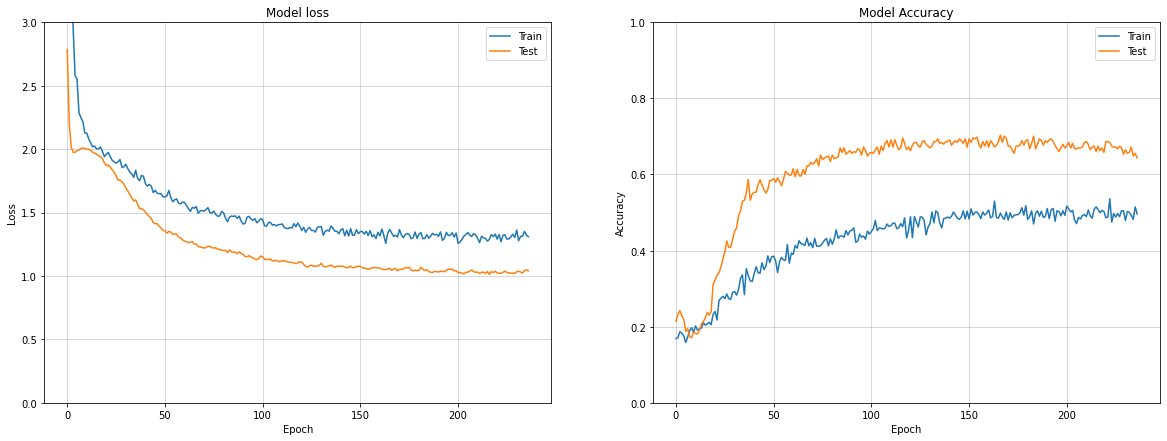

In [149]:
plot_loss_accuracy(history)

<u><b>Conclusions:</b></u>

* ❗️ If you train a Neural Network too much (too many layers, too many neurons and/or too many epochs), it will overfit very quickly

* 🥊 To prevent overfitting in Deep Learning, you can use Early Stopping, Regularization and Dropout Layers.

* ❗️ Be careful, if you use these techniques, you might end up on the other spectrum of the performance where you model would underfit the dataset!

* 🆗 You could potentially look at the batch size but we usually use 16 or 32. And as the French Computer Scientist [**Yann Lecun**](https://en.wikipedia.org/wiki/Yann_LeCun) said (Facebook x NYU):

<img src="https://github.com/lewagon/data-images/blob/master/DL/deep_learning_yann_lecun_batch_size.png?raw=true" alt="batch_size_yann_lecun" width="400" height="250">



🏁 Congratulations!

💾 Do not forget to `git add/commit/push` your notebook...

🚀 ... and move to the next challenge!